# Goal of the notebook:
```
CARTPOLE PROBLEM: Deep Policy methods: Reinforce
```

* A state in cartpole problem is defined with 4 values - cart position, cart velocity, pole angle, pole angular velocity.

* Action space - Two actions - left and right.

* Instead of having two different steps for value baselining and taking actions, directly assigning values to the actions themselves and choosing the appropriate action.

In policy based methods, we have probabilities (log probabilities are used to be practical) and there is an advantage term multiplied by some learning rate.

In Reinforce method,

The advantage term is **"Returns"**. So, when the returns are positive, it means that the respective action in the given state is correct and in the direction to take the agent closer to the objective, consequently probability associated with the respective action in the given state increases. If the returns are negative, the probability decreases.

These returns don't necessarily have to be positive and negative. They can be small or big and this can determine how close the agent is to the objective.

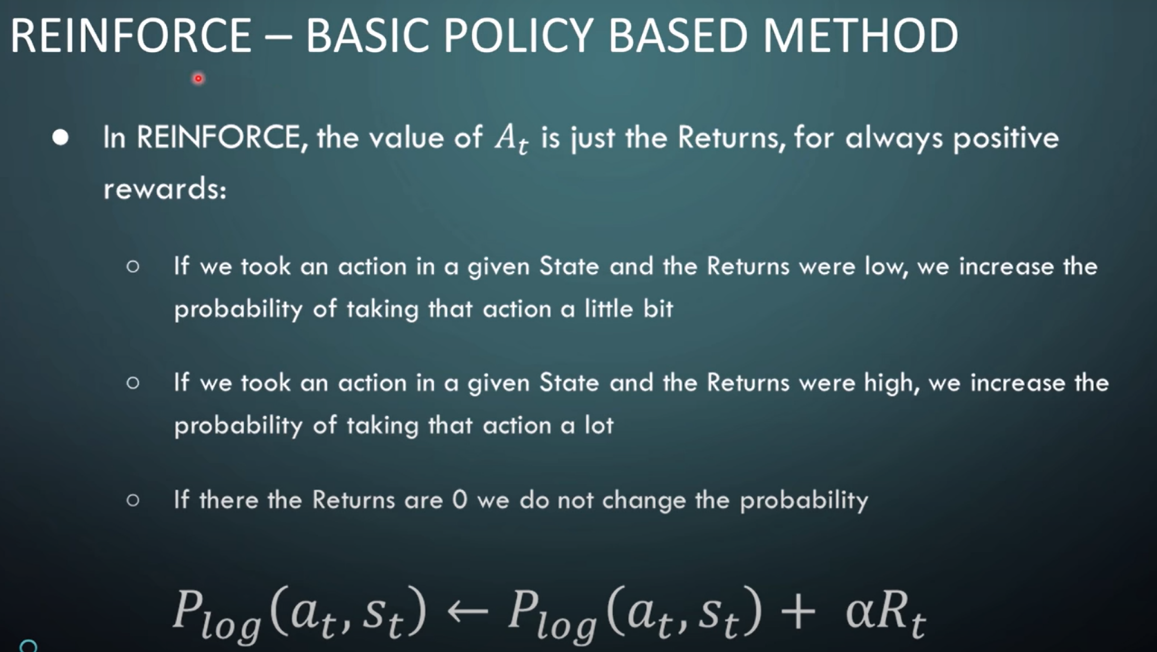

# Deep Policy methods

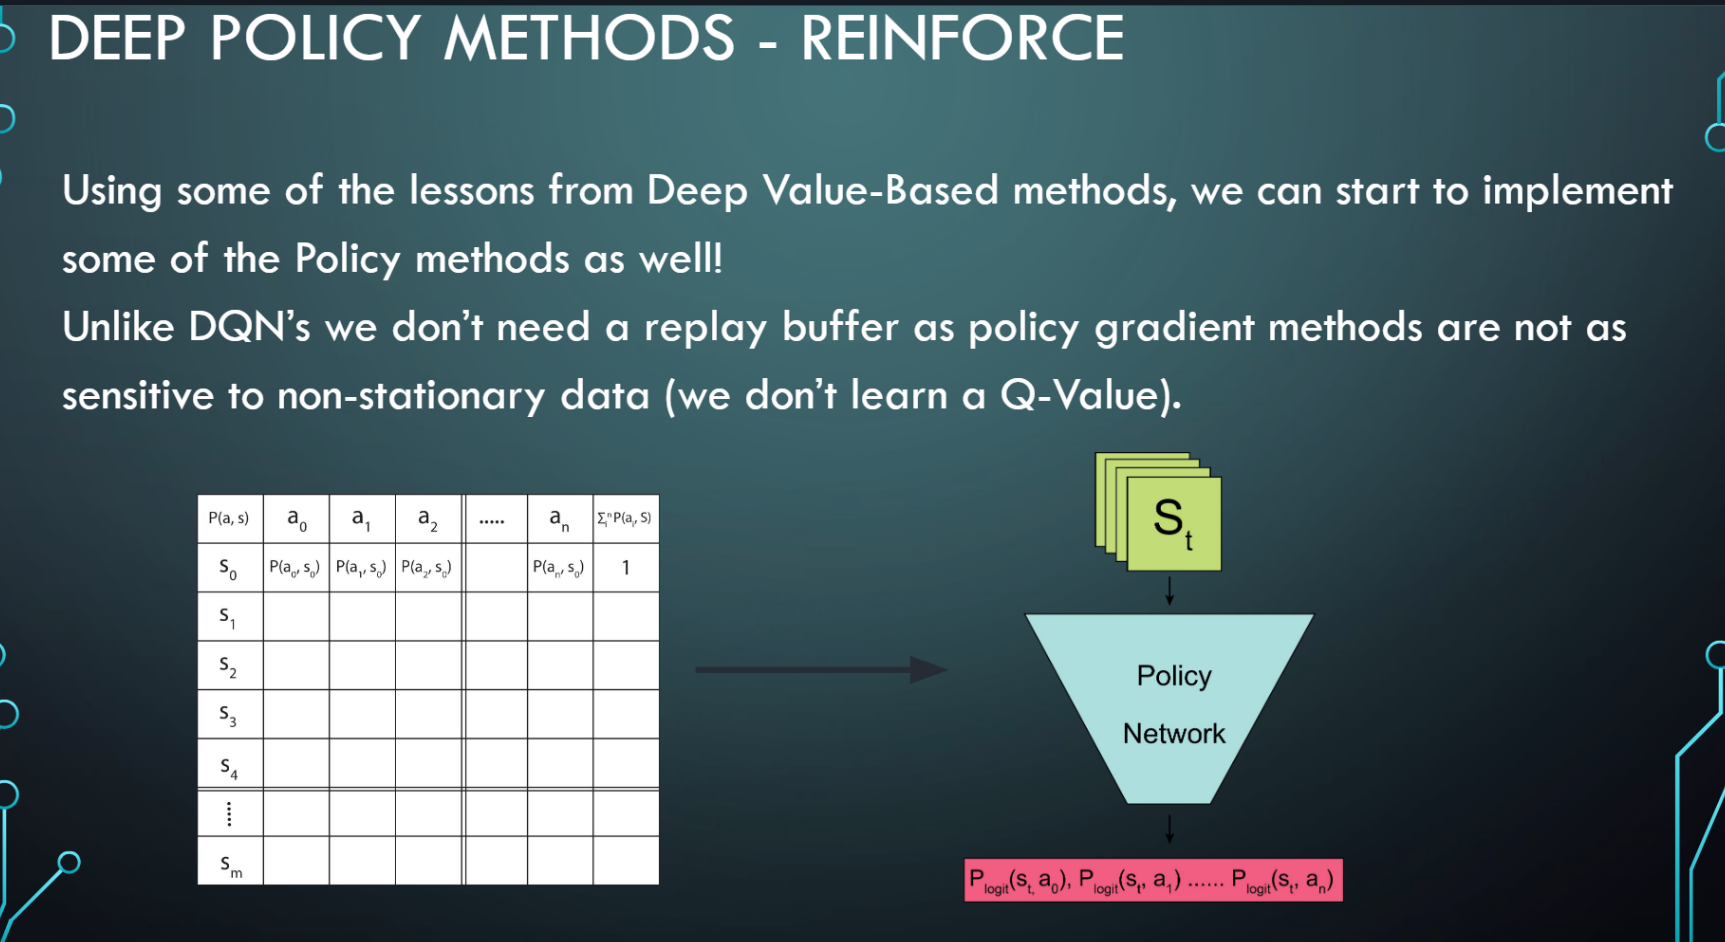

# Imports

In [8]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Configuring the Cart-Pole environment from OpenAI Gymnasium.

In [9]:
env_name = 'CartPole-v0'
env = gym.make(env_name)

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Defining the neural network

The neural networks takes in state value and gives us the possible action probabilities in the given state.

In [10]:
class RL(nn.Module):
    def __init__(self, action_num=2, hidden_size=256):
        super(RL, self).__init__()
        self.fc1 = nn.Linear(4, hidden_size) # 4 values that are needed to define the state
        self.fc2 = nn.Linear(hidden_size, action_num) # To output two values in relation to the two actions associated with the given state information

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x) # Outputs two values associated with each state
        return Categorical(logits=logits)
        # We are creating a categorical object
        # This takes in input logits and apply softmax over them giving us a probability distribution
        # We are using this instead of explicitly using torch.softmax() on our own as
        # This gives us some extra functionality like sample() and makes it easy to compute log probs.

# Test agent

The testing code that uses the trained policy network to make inferences on a single trajectory.

* Also used to compute the score in a given trajectory by computing total rewards accumulated through out the episode.

In [11]:
def calc_returns(rewards, gamma=0.99):
  returns = []
  delta = 0
  for reward in rewards[::-1]: #Rewards reverse iteration with slicing notation with [start,stop,step] with step=-1
    delta = reward + gamma * delta
    returns.insert(0,delta) # As reverse iterations, adding on forward
  return returns


def test_agent():
    done = False
    total_reward = 0
    observation = torch.FloatTensor(env.reset()).unsqueeze(0) # Initial state

    with torch.no_grad():
        while not done: # done when the episode is complete
            dist = rl_model(observation) # Send the state as input to get action distribution

            # Not following epsilon-greedy
            # Taking random action, also while respecting respective action probabilities
            # Good as takes the action with high action mostly, but some times still takes other
            # Good for exploring new states and values
            action = dist.sample().cpu().item()
            observation, reward, done, info = env.step(action) # step in Gym is taking the action at current state
            # observation -> next state upon taking respective action
            # reward # done -> done with the episode? # info -> extra information
            observation = torch.FloatTensor(observation).unsqueeze(0) # converting into a torch tensor and unsqueeze to inclue bs dimension
            total_reward += reward

    return total_reward

In [12]:
rl_model = RL() # Model instantiation
lr = 1e-3
optimizer = optim.Adam(rl_model.parameters(), lr=lr)

In [13]:
max_steps = 100000 # Much higher number of max_steps
rollouts = 0
step = 0
score_logger = []

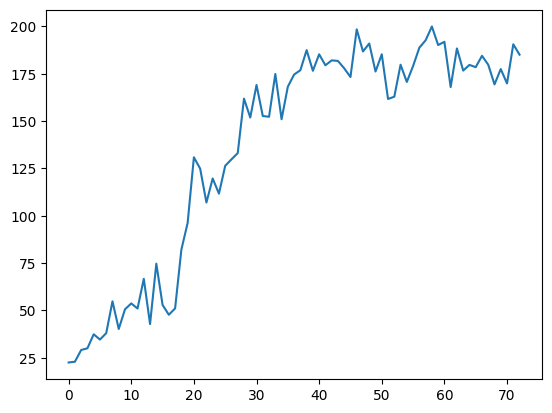

In [14]:
while step < max_steps: # step means the total number of steps across all episodes.
    observation = torch.FloatTensor(env.reset()).unsqueeze(0) # Resetting when starting an episode
    done = False
    rewards = []
    log_probs = []

    while not done: # While episode is not done
        dist = rl_model(observation) # Passing the state to the model
        action = dist.sample() # Taking a sample action from the distribution
        log_prob = dist.log_prob(action.unsqueeze(0)) # Computing the log probability of the action

        observation, reward, done, info = env.step(action.cpu().item()) # Taking the action in the gym environment

        observation = torch.FloatTensor(observation).unsqueeze(0)
        reward = torch.FloatTensor([reward]).unsqueeze(0)

        rewards.append(reward)
        log_probs.append(log_prob)

        step += 1

    returns = calc_returns(rewards)

    returns = torch.cat(returns,1)
    returns /= returns.max() # Normalizing returns as they become quite large over time
    log_probs = torch.cat(log_probs,1)

    # Loss function
    action_loss = -(log_probs * returns).sum() # 1 iteration per one trajectory
    # Not taking in values from other trajectories

    # optimizer
    optimizer.zero_grad()
    action_loss.backward()
    optimizer.step()
    rollouts+=1

    if rollouts % 10 == 0: # Update is happening every ten episodes to reduce computational overhead
            new_lr = ((max_steps - step)/max_steps) * lr
            # lr decreases with time as steps increase

            # updating learning rate in optimizer
            optimizer.param_groups[0]["lr"] = new_lr

            # Calculating score using test_agent() that accumulates rewards and taking in average of 10 such test runs
            # test_agent() just uses exploitation
            score_logger.append(np.mean([test_agent() for _ in range(10)]))

            clear_output(True)
            plt.plot(score_logger)
            plt.show()

env.close()

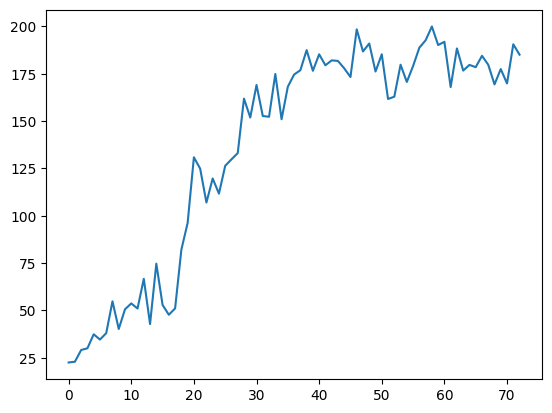

In [15]:
plt.plot(score_logger)